<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/main/master_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Project 3: Team Decision Makers***
## Jesse Kranyak &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Siriesha Mandava
## Mohamed Altoobli &nbsp;&nbsp;   Jeffery Boczkaja

# Skin Lesion Classification Project
This project focuses on classifying skin lesions using deep learning techniques. The dataset used for training and testing the model is the ISIC 2019 dataset, which consists of images of various skin lesions along with associated metadata.

## Step 1: Initial setup and Library installation
Colab requires many libraries to be installed for use everytime you run a new notebook!

In [1]:
!pip install tensorflow
!pip install isic-cli
!pip install kaggle
!pip install imblearn
!pip install optuna
!pip install tqdm
!pip install optuna-integration
!pip install pydot
!pip install gradio --upgrade
!apt-get install graphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.2 MB/s eta 0:00:00


In [2]:
import base64
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import requests
import seaborn as sns
import shutil
import tensorflow as tf

from datetime import datetime
from google.colab import drive
from imblearn.over_sampling import SMOTE
from IPython.display import Image
from optuna.integration import TFKerasPruningCallback
from pathlib import Path
from PIL import Image

from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import SimpleImputer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout,
                                     Flatten, GlobalAveragePooling2D,
                                     Input, MaxPooling2D, concatenate)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import Sequence, plot_model, to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tqdm import tqdm
import gradio as gr
from optuna.integration import TFKerasPruningCallback

## Step 2: Query the Dataset
In this step, we interact with the ISIC API to query the dataset directly. We use specific API endpoints to perform operations such as listing available images, retrieving image metadata, and downloading images. This section covers setting up API requests, managing data retrieval, and handling query parameters to filter the dataset based on criteria such as diagnosis, image type, or other metadata.

In [3]:
! isic user login

visit the following url in a browser:
https://api.isic-archive.com/oauth/authorize?response_type=code&client_id=RpCzc4hFjv5gOJdM2DM2nBdokOviOh5ne63Tpn7Q&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=1bkfDoc1YvfDKaZktLrjIHV8981Kh9&code_challenge=OuDfUEiraaQZul3nPBgZyT31_Hn089YqTiQwAtVn30U&code_challenge_method=S256
enter the code shown in your browser: xZqMc5q9UcnXroog4qAXe6NyqSnkZe
Success!


In [4]:
!isic collection list

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                                          ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                                      │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test                          │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training                      │ True   │ True   │ True   │ None            │
│ 69  │ Challenge 2017: Test                          │ True   │ True   │ True   │ None            │
│ 60  │ Challenge 2017: Training                      │ True   │ True   │ True   │ None            │
│ 71  │ Challenge 2017: Validation                    │ True   │ True   │ True   │ None            │
│ 64  │ Challenge 2018: Task 1-2: Test                │ True   │ True   │ True   │ None    

In [5]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Be sure to have kaggle API key ready to go in .json file. Place it into the 'content' folder.

####Necessary Mdels and Datasets are available in Git Repo folder:

#####saved_models_for_final_project

In [6]:
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")



find the data set on kaggle

Comment out if running and already have downloaded images

In [7]:
!kaggle datasets download -d andrewmvd/isic-2019


100% 9.09G/9.10G [01:30<00:00, 166MB/s]
100% 9.10G/9.10G [01:30<00:00, 108MB/s]


In [8]:
!unzip -q isic-2019.zip


## Step 3: Data Preparation and Preprocessing DICOM Images
This step involves handling the metadata for the ISIC 2019 dataset, which which will be used for training, testing, and validation data. The processes highlighted in this step are crucial for understanding the dataset's structure and preparing it for subsequent analysis.

IMPORTANT NOTE we removed the DICOM image sets from this project for ease of processing on our colab wallets...




In [9]:
# Load the metadata
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

# Display the first few rows of each DataFrame
metadata.head()


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [10]:
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
ground_truth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Load the CSV files
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

image_dir = Path('/content/ISIC_2019_Training_Images')
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: image_dir / f"{x}.jpg")

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,80.0,posterior torso,NaN,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007325...,55.0,palms/soles,BCN_0002083,female


In [12]:
# Display the image paths for the first few entries
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Images/ISIC_000000...
1    /content/ISIC_2019_Training_Images/ISIC_000000...
2    /content/ISIC_2019_Training_Images/ISIC_000000...
3    /content/ISIC_2019_Training_Images/ISIC_000000...
4    /content/ISIC_2019_Training_Images/ISIC_000000...
Name: image_path, dtype: object


In [13]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [14]:
img_path = full_metadata['image_path']

In [15]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)


In [16]:
full_metadata = pd.get_dummies(full_metadata, columns=['sex'])


In [17]:
# Handle missing values in 'lesion_id'
full_metadata['lesion_id'].fillna('unknown', inplace=True)

# Convert booleans to integers
bool_columns = ['sex_female', 'sex_male', 'sex_unknown']
full_metadata[bool_columns] = full_metadata[bool_columns].astype(int)

# One-hot encoding of 'anatom_site_general'
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general'])

# Ensure all floating point columns are float32
float_columns = full_metadata.select_dtypes(include=['float64']).columns
full_metadata[float_columns] = full_metadata[float_columns].astype('float32')

# Convert boolean columns from one-hot encoding to integers
for col in full_metadata.columns:
    if full_metadata[col].dtype == 'bool':
        full_metadata[col] = full_metadata[col].astype(int)

# Normalize the 'age_approx' column (Optional: based on model requirements)
full_metadata['age_approx'] = full_metadata['age_approx'].astype('float32') / 100

full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   image                                25331 non-null  object 
 1   MEL                                  25331 non-null  float32
 2   NV                                   25331 non-null  float32
 3   BCC                                  25331 non-null  float32
 4   AK                                   25331 non-null  float32
 5   BKL                                  25331 non-null  float32
 6   DF                                   25331 non-null  float32
 7   VASC                                 25331 non-null  float32
 8   SCC                                  25331 non-null  float32
 9   UNK                                  25331 non-null  float32
 10  image_path                           25331 non-null  object 
 11  age_approx                  

In [18]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   image                                25331 non-null  object 
 1   MEL                                  25331 non-null  float32
 2   NV                                   25331 non-null  float32
 3   BCC                                  25331 non-null  float32
 4   AK                                   25331 non-null  float32
 5   BKL                                  25331 non-null  float32
 6   DF                                   25331 non-null  float32
 7   VASC                                 25331 non-null  float32
 8   SCC                                  25331 non-null  float32
 9   UNK                                  25331 non-null  float32
 10  image_path                           25331 non-null  object 
 11  age_approx                  

In [19]:
# Save the cleaned and encoded DataFrame to a CSV file
full_metadata.to_csv('/content/full_metadata.csv', index=False)

##Step 4: Experimenting on the TT&V

### Splitting Data into Training, Validation, and Testing Sets

The dataset is initially split into training and temporary sets, with the temporary set reserved for further division into validation and test sets. This method ensures that the model can be trained extensively, validated accurately, and finally tested to evaluate its performance on unseen data.

###results before image input augmentation part 2
###Test 1, no modification 68% acc score, val_acc, terrible F1 & confusion
###After augmenting
###Test 2, resampling 62% acc score, lower val_acc, terrible F1 & confusion

| Class | Count    |
|-------|----------|
| MEL   | 20651.0  |
| NV    | 6957.0   |
| BCC   | 25309.0  |
| AK    | 77387.0  |
| BKL   | 30227.0  |
| DF    | 261561.0 |
| VASC  | 261561.0 |
| SCC   | 99679.0  |


###Test 3, weighted resampling 69.1%, improving metrics, bad F1

| Class | Samples  |
|-------|----------|
| MEL   | 373.0    |
| NV    | 130.0    |
| BCC   | 504.0    |
| AK    | 7682.0   |
| BKL   | 644.0    |
| DF    | 268194.0 |
| VASC  | 268194.0 |
| SCC   | 15448.0  |

###Test 4 , 62% acc
New class counts after resampling w communism:

| Class | Samples |
|-------|---------|
| MEL   | 191.0   |
| NV    | 191.0   |
| BCC   | 191.0   |
| AK    | 191.0   |
| BKL   | 191.0   |
| DF    | 191.0   |
| VASC  | 191.0   |
| SCC   | 191.0   |

###Test 5, lets try a different kind of distribution and classify the critically important (malignant) lesions with more weight: 67.13% acc, but this is the first and only method getting F1 scores in all catagories. for final run we will apply a second 10x layer of training at the .fit and conditionally train for low F1 results from this TTSV set and go with it...

| Class | Samples |
|-------|---------|
| MEL   | 3618.0  |
| NV    | 10300.0 |
| BCC   | 2658.0  |
| AK    | 694.0   |
| BKL   | 2099.0  |
| DF    | 191.0   |
| VASC  | 202.0   |
| SCC   | 502.0   |


####Not much happening with this adjustment, will leave it weighted, specifically on malignant classes and start hypertuning

####We end up additionally adding in a 10x on lowest f1 scores of this run





In [95]:
# Assuming 'full_metadata' is your complete dataset and properly loaded
X = full_metadata.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
y = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']]

# Define class weights based on your specification
weights = {
    'MEL': 10.0, 'NV': 1.0, 'BCC': 10.0, 'AK': 1.0, 'BKL': 1.0,
    'DF': 10.0, 'VASC': 1.0, 'SCC': 10.0
}

# Calculate class totals and total samples for weight adjustments
class_totals = y.sum()
total_samples = y.sum().sum()

# Compute weights inversely proportional to class frequencies
class_weights = total_samples / (len(class_totals) * class_totals)

# Adjust weights according to your specific weights
adjusted_weights = {key: weights[key] for key in weights}

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Output the class weights for reference
print("New class counts after resampling:\n", y_train.sum())

New class counts after resampling:
 MEL      3618.0
NV      10300.0
BCC      2658.0
AK        694.0
BKL      2099.0
DF        191.0
VASC      202.0
SCC       502.0
dtype: float32


In [96]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(20264, 16) (20264, 8)
(2533, 16) (2533, 8)
(2534, 16) (2534, 8)


## Step 5: First Model Preparation and Training

We will use a Dual Input Generator we custom built for our first model and the following steps will prep, then train our model.

### Dual Input Data Generator

The `DualInputGenerator` class is a custom data generator for handling datasets that include both image paths and associated metadata. It is designed to work with Keras/TensorFlow, enabling efficient batch processing which is crucial for training deep learning models on large datasets. Here's a breakdown of its functionality:

- **Initialization (`__init__`)**: This method sets up the generator with all necessary parameters, including image paths, metadata, and labels. It also initializes the batch size, image size, and whether the dataset should be shuffled during training to introduce randomness into the training process.

- **Preprocessing (`preprocess_image`)**: A helper function to read and preprocess images. It converts images to the appropriate size and scale ([224x224] in this case) and normalizes pixel values to the range [0, 1].

- **Length Calculation (`__len__`)**: This method calculates how many batches are in the dataset, which is used by Keras during training to determine the number of steps per epoch.

- **Batch Generation (`__getitem__`)**: This method retrieves a batch of data by processing the images, metadata, and labels. It loads and preprocesses the images specified by the batch indexes, extracts the corresponding metadata, and gathers the labels. The function returns a list containing two arrays (images and metadata) and the batch of labels.

- **Epoch End Handling (`on_epoch_end`)**: If shuffling is enabled, this method shuffles the indexes after each epoch to ensure that the model does not see the same sequence of batches every epoch, helping the model to generalize better.

This structured approach ensures that the model receives properly formatted and preprocessed data for each training step, facilitating effective learning and performance improvement.


####Updated input generator to provide code for more data augmentation on images, using

1.   flip: left and right
2.   brightness & contrast shifting

#####Not a large effect noticed in this type of augmentation on our specific model

Granted, due to time constraints we did not run multiple experiments on iterating the #commented_out lines of augmentation. This culd have major impacts on the final results, would be great to experiment with an optimizer for these parameters



In [97]:
class DualInputGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def preprocess_image(self, file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = img / 255.0  # Normalize to [0, 1]

        # Apply data augmentation
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

        # Additional augmentations can be added here, this is a complete list of optoins
        # uncomment for experimentation:

        # Randomly flip the image up and down
        #img = tf.image.random_flip_up_down(img)
        # Randomly crop the image
        #img = tf.image.random_crop(img, size=[desired_height, desired_width, channels])
        # Adjust the hue of the image randomly
        #img = tf.image.random_hue(img, max_delta=0.08)
        # Adjust the saturation of the image randomly
        #img = tf.image.random_saturation(img, lower=0.7, upper=1.3)
        # Rotate the image randomly
        img = tfa.image.rotate(img, angles=tf.random.uniform(shape=[], minval=-0.2, maxval=0.2))
        # Add random noise to the image
        #noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1, dtype=tf.float32)
        img = tf.add(img, noise)
        # Apply a random transformation that performs a combination of affine transformations
        #img = tfa.image.transform(img, transforms=[1, 1, -10, 0, 1, 0, 0, 0], interpolation="NEAREST")
        # Randomly adjust the gamma of the image
        #img = tf.image.adjust_gamma(img, gamma=0.9, gain=1)
        # Add random cutout (a patch set to zero)
        #mask_size = 50  # Size of the square mask
        #pad_size = tf.maximum(tf.shape(img)[0], tf.shape(img)[1])
        #padded_img = tf.image.pad_to_bounding_box(img, pad_size, pad_size, pad_size * 2, pad_size * 2)
        #cutout_area = tf.zeros((mask_size, mask_size, 3))
        #padded_cutout = tf.image.pad_to_bounding_box(cutout_area, pad_size//2 - mask_size//2, pad_size//2 - mask_size//2, pad_size * 2, pad_size * 2)
        #img = tf.where(tf.equal(padded_cutout, 0), padded_img, img)
        #img = tf.image.crop_to_bounding_box(img, pad_size, pad_size, tf.shape(img)[0], tf.shape(img)[1])

        return img

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        end_idx = min(end_idx, len(self.image_paths))
        current_batch_size = end_idx - start_idx

        X_images = np.empty((current_batch_size, *self.img_size, 3))
        X_metadata = np.empty((current_batch_size, self.metadata.shape[1]))
        y = np.empty((current_batch_size, self.labels.shape[1]), dtype=int)

        for i, idx in enumerate(range(start_idx, end_idx)):
            img_path = self.image_paths[idx]
            img = self.preprocess_image(img_path)
            X_images[i, ] = img
            X_metadata[i, ] = self.metadata[idx]
            y[i, ] = self.labels[idx]

        return [X_images, X_metadata], y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


### Initializing Data Generators for Training, Validation, and Testing

To ensure our model is trained, validated, and tested with data that is efficiently loaded and preprocessed, we initialize three instances of the `DualInputGenerator` class:

- **Training Generator (`train_gen`)**: This generator is configured with training data paths, metadata, and labels. It is responsible for feeding the training data into the model in batches of 32, ensuring that each batch is shuffled to promote model generalization.

- **Validation Generator (`val_gen`)**: Similar to the training generator, but using the validation dataset. This generator provides data for evaluating the model during the training process, allowing us to monitor the model's performance and make adjustments if needed without seeing the test data.

- **Testing Generator (`test_gen`)**: Finally, the testing generator is set up using the test dataset to evaluate the model's performance after training has been completed. This step is crucial for assessing how well the model is likely to perform on unseen real-world data.

Each generator uses the `image_paths`, `metadata`, and `labels` from their respective subsets of the data, ensuring that the model receives all necessary inputs for making predictions during each phase of the training and evaluation process.



In [98]:
# Initialize the training generator with image size parameter
train_gen = DualInputGenerator(
    image_paths=X_train['image_path'].values,
    # Once weve retrieved the image paths, we need to drop the columns we did not encode
    metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_train.values,
    batch_size=32,
    img_size=(224, 224)
)

# Initialize the validation generator with image size parameter
val_gen = DualInputGenerator(
    image_paths=X_val['image_path'].values,
    metadata=X_val.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_val.values,
    batch_size=32,
    img_size=(224, 224)
)

# Initialize the test generator with image size parameter
test_gen = DualInputGenerator(
    image_paths=X_test['image_path'].values,
    metadata=X_test.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_test.values,
    batch_size=32,
    img_size=(224, 224)
)

# Example line to check if the image paths from X_test are being accessed correctly
print(X_test['image_path'].values)


['/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0031599.jpg'
 '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0057178.jpg'
 '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0060330.jpg'
 ...
 '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056152.jpg'
 '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0070938.jpg'
 '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0057966.jpg']


### Dual Input Neural Network Architecture

The neural network architecture is designed to handle two types of input: images and metadata. Here's a breakdown of the model architecture and the role of each component:

#### Image Input Branch
- **Image Input**: The model starts with an image input layer that accepts images of shape (224, 224, 3).
- **Convolution and Pooling Layers**: Following the input, the model includes two sets of convolutional layers (`Conv2D`) and max pooling layers (`MaxPooling2D`). Each convolutional layer is followed by batch normalization (`BatchNormalization`), which helps to accelerate the training process and stabilize the learning environment by normalizing the activations.
- **Flattening and Dense Layer**: After extracting and pooling features through convolutions, the data is flattened (`Flatten`) and passed through a dense layer with ReLU activation, which is again batch normalized.

#### Metadata Input Branch
- **Metadata Input**: This branch begins with an input for metadata features, shaped dynamically based on the number of metadata features (`num_metadata_features`).
- **Dense Layers and Normalization**: It includes dense layers (`Dense`) with ReLU activation, interspersed with batch normalization to ensure the model learns effectively from the structured data.

#### Combining Branches
- **Concatenation**: The outputs of the image and metadata branches are combined into a single vector (`concatenate`), allowing the model to learn from both image features and metadata simultaneously.
- **Final Dense Layers**: The combined data is then passed through additional dense layers, including a dropout layer (`Dropout`) to prevent overfitting, culminating in a softmax output layer (`Dense`) that classifies the images into one of nine diagnostic categories.



In [99]:
num_metadata_features = X_train.drop(columns=['image', 'image_path', 'lesion_id']).shape[1]
print("Number of metadata features:", num_metadata_features)


Number of metadata features: 13


###Our Custom Multi-Input Neural Network
This model was based on class lessons, internet research and utilizing chatgpt4's 'Python' Bot

In [100]:
num_metadata_features = 13

def create_model():
  # Image input branch
  image_input = Input(shape=(224, 224, 3), name='image_input')
  x = Conv2D(32, (3, 3), activation='relu')(image_input)
  # Add batch normalization here
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  # Add batch normalization here
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)
  image_branch = Dense(128, activation='relu')(x)
  image_branch = BatchNormalization()(image_branch)

  # Metadata input branch
  metadata_input = Input(shape=(num_metadata_features,), name='metadata_input')
  y = Dense(32, activation='relu')(metadata_input)
  # Normalize after the first dense layer
  metadata_branch = BatchNormalization()(y)
  metadata_branch = Dense(64, activation='relu')(metadata_branch)
  # Normalize before combining
  metadata_branch = BatchNormalization()(metadata_branch)

  # Combine the outputs of the two branches
  combined = concatenate([image_branch, metadata_branch])
  z = Dense(256, activation='relu')(combined)
 # Adding dropout for regularization
  z = Dropout(0.2232357393141235)(z)
  # Adjust the number of units to match the number of classes
  output = Dense(8, activation='softmax')(z)

  #  Create the model
  model = Model(inputs=[image_input, metadata_input], outputs=output)

  # Adjust the learning rate if testing indicates it's beneficial
  # Start with your last setting and adjust based on performance
  learning_rate = 1e-5

  return model

##Augmentaion of Automated hyperparameter optimization ☄

After numerous trials we are unable to break the low 70% accuracies, and low 60'S for val_acc, we will try some hypertuning...

### How Optuna Chooses the Optimizer:
In your objective function, you specify a categorical distribution for the optimizer using `trial.suggest_categorical()`. This function tells Optuna to randomly choose one of the provided options for each trial.

### Optuna's Optimization Algorithms:
Optuna uses several algorithms to optimize the search for the best hyperparameters:

- **Tree-structured Parzen Estimator (TPE):** A default and commonly used approach that models the search space using Bayesian optimization.
- **CMA-ES:** An evolutionary algorithm suitable for optimizing in continuous spaces, which can be more effective when many trials are possible. THIS IS OUR APPLICATION OF HYPERTUNING
- **Random Search and Grid Search:** Simpler methods that are sometimes used, particularly random search in the early phases of a study.


###Extra method set here to reduce time;

def objective_and_fit_wrapper(trial):

Parallelize Computations: Structuring our model and computations to maximize parallelism, allowing the TPU to efficiently utilize its cores. This lets us run more epochs faster. We also applied pruning to the studies and that will end the early identified losers more rapidly.  **method does NOT work in colab**

In [ ]:
class DualInputGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def preprocess_image(self, file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.img_size)
        img = img / 255.0
        return img

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        end_idx = min(end_idx, len(self.image_paths))
        current_batch_size = end_idx - start_idx
        X_images = np.empty((current_batch_size, *self.img_size, 3))
        X_metadata = np.empty((current_batch_size, self.metadata.shape[1]))
        y = np.empty((current_batch_size, self.labels.shape[1]), dtype=int)
        for i, idx in enumerate(range(start_idx, end_idx)):
            img_path = self.image_paths[idx]
            img = self.preprocess_image(img_path)
            X_images[i, ] = img
            X_metadata[i, ] = self.metadata[idx]
            y[i, ] = self.labels[idx]
        return [X_images, X_metadata], y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

def build_model(learning_rate, dropout_rate, num_metadata_features):
    image_input = Input(shape=(224, 224, 3), name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    image_branch = Dense(128, activation='relu')(x)
    image_branch = BatchNormalization()(image_branch)

    metadata_input = Input(shape=(num_metadata_features,), name='metadata_input')
    y = Dense(32, activation='relu')(metadata_input)
    metadata_branch = BatchNormalization()(y)
    metadata_branch = Dense(64, activation='relu')(metadata_branch)
    metadata_branch = BatchNormalization()(metadata_branch)

    combined = concatenate([image_branch, metadata_branch])
    z = Dense(256, activation='relu')(combined)
    z = Dropout(dropout_rate)(z)
    output = Dense(8, activation='softmax')(z)

    model = Model(inputs=[image_input, metadata_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def objective_and_fit(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    model = build_model(learning_rate, dropout_rate, 13)
    train_gen = DualInputGenerator(X_train['image_path'].values, X_train.drop(columns=['image', 'image_path', 'lesion_id']).values, y_train.values, batch_size)
    val_gen = DualInputGenerator(X_val['image_path'].values, X_val.drop(columns=['image', 'image_path', 'lesion_id']).values, y_val.values, batch_size)
    # Add TFKerasPruningCallback to enable pruning at each epoch
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        TFKerasPruningCallback(trial, 'val_accuracy')  # Monitor validation accuracy for pruning
    ]
    history = model.fit(train_gen, epochs=3, validation_data=val_gen, callbacks=callbacks, verbose=1)
    max_val_accuracy = np.max(history.history['val_accuracy'])
    return max_val_accuracy

# Set up parallelism for Optuna
def objective_and_fit_wrapper(trial):
    return objective_and_fit(trial)

if __name__ == '__main__':
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,  # Number of trials to run before pruning starts
        n_warmup_steps=2,    # Number of steps to run before starting to apply prune logic
        interval_steps=1     # Interval steps to apply pruning
    )

    study = optuna.create_study(direction='maximize', pruner=pruner)

    # Uncomment the line below to run the optimization
    #study.optimize(objective_and_fit_wrapper, n_trials=50)
    #makin 1 study for turning in
    study.optimize(objective_and_fit_wrapper, n_trials=10)
    print("Best hyperparameters: ", study.best_trial.params)



[I 2024-04-23 03:17:46,154] A new study created in memory with name: no-name-4a94f162-3137-44d8-9c81-82fcacbc1a28


Epoch 1/3
594/633 [===========================>..] - ETA: 23s - loss: 1.2873 - accuracy: 0.5593

#### Model Compilation
- Now we can implement the hypertuned parameters discovered in the previous steps... fingers crossed we get a better output.  This process is automated, as the runtime of the above step is long.
- The model was originally compiled with the Adam optimizer, using a learning rate of 1e-4. The loss function used is categorical crossentropy, suitable for multi-class classification tasks, and accuracy is used as the metric to evaluate model performance.  This hsould update the model to a specific Adam based learning rate

This dual-input setup allows the model to leverage both detailed image data and accompanying metadata, aiming to improve diagnostic accuracy compared to using images or metadata alone.


In [ ]:
# Retrieve the best hyperparameters
best_params = study.best_trial.params
best_learning_rate = best_params['learning_rate']
best_optimizer_name = best_params['optimizer']

# Choose the optimizer based on the best hyperparameters found
if best_optimizer_name == 'adam':
    optimizer = Adam(learning_rate=best_learning_rate)
else:
    optimizer = RMSprop(learning_rate=best_learning_rate)

# Compile the model with the best hyperparameters
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)


###Manual save in case colab boots us...
run these 2 cells instead of the 2 cells above to save 15 - 96 hours

comented out parameters from previous runs

In [102]:
# # best param for current setup of T.T.S.V.
# best_params = {
#     'learning_rate': 0.00012617133871374036,
#     'optimizer': 'rmsprop',
#     'batch_size': 32,
#     'objective_value': 0.6673259735107422
# }

# # Save the parameters to disk
# with open('/content/drive/My Drive/best_hyperparams.pkl', 'wb') as f:
#     pickle.dump(best_params, f)




In [103]:
# # Load the saved parameters
# with open('/content/drive/My Drive/best_hyperparams.pkl', 'rb') as f:
#     best_params = pickle.load(f)

# # Assume `model` is your pre-existing model that you've already defined and compiled somewhere in your code

# # Configure the optimizer based on the loaded parameters
# if best_params['optimizer'] == 'adam':
#     optimizer = Adam(learning_rate=best_params['learning_rate'])
# elif best_params['optimizer'] == 'rmsprop':
#     optimizer = RMSprop(learning_rate=best_params['learning_rate'])
# else:
#     raise ValueError("Unsupported optimizer: {}".format(best_params['optimizer']))

# # Set the new optimizer to the model
# optimizer = Adam(learning_rate=0.00012617133871374036)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


### Configuring Callbacks for Model Training

To enhance the training process and ensure optimal model performance, we use a combination of callbacks in TensorFlow. These callbacks are set to monitor the training process and make decisions at the end of each epoch. Here's a breakdown of each callback used:

#### EarlyStopping
- **Purpose**: Prevents overfitting by halting the training if the model's validation loss does not improve for a specified number of consecutive epochs.
- **Configuration**:
  - `monitor='val_loss'`: Watches the validation loss metric for changes.
  - `patience=2`: Allows the training to continue for 2 epochs without improvements in validation loss, we will run more later with a higher patience level.
  - `verbose=1`: Enables logging for when the training is stopped early.

#### ModelCheckpoint
- **Purpose**: Saves the model in its current state after each epoch, but only if the model's performance (based on the monitored metric) has improved.
- **Configuration**:
  - `filepath='best_model.keras'`: Specifies the location and filename where the best model version will be saved.
  - `monitor='val_loss'`: Monitors the validation loss for improvements.
  - `save_best_only=True`: Ensures that the model is saved only when its validation loss is at its lowest point seen so far.
  - `verbose=1`: Provides detailed logs when the model is saved.

These callbacks are essential tools for managing long training sessions effectively. They help conserve resources by stopping training when additional epochs would not lead to improvements (`EarlyStopping`) and by ensuring that only the best model version is saved (`ModelCheckpoint`), thus simplifying deployment and further evaluation.


In [ ]:
checkpoint_path = "/content/drive/My Drive/Colab Models/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=3,
                  # Allows some room for loss to decrease again
                  patience=10,
                  # Stops training if the loss goes above 0.2
                  baseline=0.25,
                  restore_best_weights=True
                  ),


    ModelCheckpoint(filepath='best_model.keras',
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1
                    )
]

### Training the Model
#### AND Re-Training, the first model resulted in 70%acc, 61% val_acc this is after going back to do futher augmentation

To train the dual-input model, we use the `model.fit` method provided by TensorFlow. This method executes the training cycle across a specified number of epochs, allowing for detailed monitoring and adjustments during the training process. Here's a breakdown of each parameter used in the `model.fit` call:

- **train_gen**: The training data generator, which supplies batches of image and metadata inputs along with the corresponding labels.
- **validation_data**: The validation data generator used to evaluate the model at the end of each epoch, helping monitor its performance on unseen data.
- **epochs**: Sets the total number of training cycles the model will undergo. In this case, the model is set to train for 10 epochs.
- **steps_per_epoch**: Specifies the number of batch steps to complete one epoch. This is set to the total number of batches available in the training generator (`len(train_gen)`), ensuring that each sample is used once per epoch.
- **validation_steps**: Determines the number of batch steps used for validating the model, set to the length of the validation generator.
- **callbacks**: Includes the `EarlyStopping` and `ModelCheckpoint` callbacks configured previously. These enhance the training process by:
  - **EarlyStopping**: Automatically stops training when the validation loss ceases to decrease, preventing overfitting.
  - **ModelCheckpoint**: Saves the best version of the model based on validation loss, ensuring that only the most accurate model is retained.

This configuration ensures that the model is not only trained but also validated effectively, with checkpoints saved automatically and training potentially halted early if no further gains are observed. This approach optimizes both the efficiency and efficacy of the model training process.



####Adding in extra step in epoch training to account for low F1 scores in underrepresented classes
- conditional training for underrepresented classes built into 2 epoch steps
- regular training for the rest of our epochs


In [ ]:
# Define underrepresented classes based on higher class weights or lower presence
underrepresented_classes = ['MEL', 'BCC', 'DF', 'SCC']  # Adjusted to represent lowest f1 score
# Filter y_train to get indices where any of the underrepresented classes occur
underrepresented_indices = y_train[underrepresented_classes].sum(axis=1) > 0

# Filter X_train and y_train to get only the samples belonging to underrepresented classes
X_train_underrepresented = X_train[underrepresented_indices]
y_train_underrepresented = y_train[underrepresented_indices]


In [ ]:
# for epoch in range(10):
for epoch in range(1):
    print(f"Epoch {epoch+1}/10")
    if epoch % 5 == 0:
        print("Focusing on underrepresented classes")
        current_gen = DualInputGenerator(
            image_paths=X_train_underrepresented['image_path'].values,
            metadata=X_train_underrepresented.drop(columns=['image', 'image_path', 'lesion_id']).values,
            labels=y_train_underrepresented.values,
            batch_size=32
        )
    else:
        print("Training on full dataset")
        current_gen = DualInputGenerator(
            image_paths=X_train['image_path'].values,
            metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
            labels=y_train.values,
            batch_size=32
        )

# Map class labels to indices
class_labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']  # ensure this order matches your DataFrame columns for y
class_indices = {label: idx for idx, label in enumerate(class_labels)}

# Adjust weights dictionary to use integer indices
adjusted_weights_indices = {class_indices[key]: value for key, value in weights.items()}

# Now the class weights can be correctly understood by Keras
print(adjusted_weights_indices)

#Use these adjusted class weights in your training
history = model.fit(
        current_gen,
        validation_data=val_gen,
        epochs=1,  # Run one epoch at a time
        steps_per_epoch=len(current_gen),
        validation_steps=len(val_gen),
        callbacks=callbacks,
        class_weight=adjusted_weights_indices
    )

In [ ]:
# Accessing training history
print(history.history.keys())  # List of available metrics

# Example: Accessing training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Example: Plotting training and validation loss over epochs
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We can see here that val_loss isnt doing anything, so we might want to start this workflow all over in a new notebook and re-impliment ReduceLROnPlateau to try and address the learning rate.  Problem would likely fix itself after a full Optuna run... if we only had another week to wait for it to finish ⛵

Whats intersting is it looks like its geting more diverse training on all classes! lets go check out the new F1 scores ⏩

In [109]:
# Evaluate the model on the test set
results = model.evaluate(test_gen, steps=len(test_gen))
test_loss, test_accuracy = results

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


79/79 [==============================] - 29s 366ms/step - loss: 2.3377 - accuracy: 0.5894
Test Loss: 2.3376569747924805
Test Accuracy: 0.5893987417221069


In [86]:
model.save('/content/best_model.keras')  # Saves the model to the specified path

print("Model saved successfully to '/content/best_model.keras'")

Model saved successfully to '/content/best_model.keras'


## Step 6: Model Summary and Visualization

The `model.summary()` method outputs the architecture of the model, listing each layer, its type, output shape, and number of parameters. This helps understanding the depth and complexity of the model's structure. Additionally, the `plot_model` function is used to generate a graphical representation of the model, which includes the shapes and names of each layer, offering a visual reference of the model's design.

### Generating and Evaluating Predictions

After training, predictions are generated for the test set using the `model.predict` method. This function computes the model's output predictions. The `np.argmax` function is then applied to these predictions to convert the model outputs from probabilities to explicit class predictions.

### Collecting True Classes and Generating Confusion Matrix

To evaluate the accuracy of our model's predictions, it is necessary to compare these predicted classes against the true classes from the test set. This comparison is facilitated through the collection of true class labels directly from the test generator. Subsequently, a confusion matrix is generated using the `confusion_matrix` function. This matrix visualizes the performance of a classification model, showing the actual versus predicted classifications, which helps in identifying how well the model is performing with respect to different classes. The `seaborn.heatmap` function is then used to plot the confusion matrix, providing a color-coded visualization of the results, which makes it easier to interpret the model's accuracy and misclassifications.



In [35]:
!pip install pydot
!apt-get install graphviz
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: Could not build wheels for pygraphviz, which is required to install pyproject.toml-based projects


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['image_input[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 222, 222, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['batch_normalization[0][0

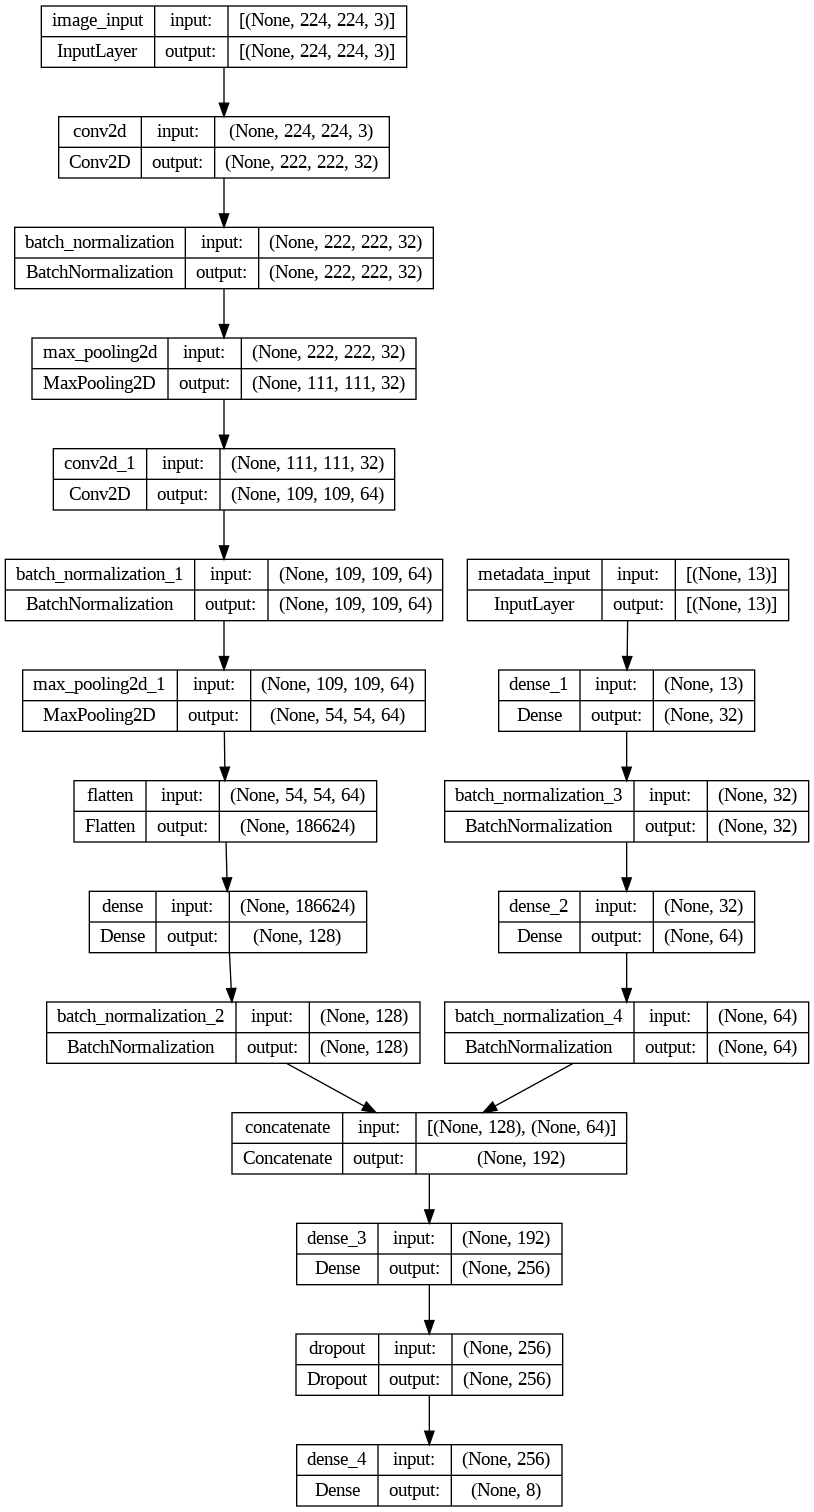

In [81]:
model.summary()

# Generate a plot of the model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


In [111]:
# Generate predictions using the test generator
predictions = model.predict(test_gen, steps=len(test_gen))

# Obtain the predicted classes by taking the argmax of the predictions array
predicted_classes = np.argmax(predictions, axis=1)

# test_gen should also be outputting the true classes in the same order as the predictions:
# We need to collect all true classes from the generator (in the same order)
true_classes = []
for _, labels in test_gen:
    true_classes.extend(np.argmax(labels, axis=1))
    if len(true_classes) >= len(predictions):
        break  # Stop once we have all the labels we need

# Generate the confusion matrix
cm = confusion_matrix(true_classes[:len(predictions)], predicted_classes)

print(cm)

79/79 [==============================] - 29s 360ms/step
[[255  96  32  36  24   0   0   7]
 [246 932  41  26  38   1   0   1]
 [ 70  29 132  57  36   0   1   7]
 [ 22   1  22  30  10   0   0   1]
 [ 77  45  35  34  70   0   0   2]
 [  7   6   4   4   1   1   0   1]
 [  9   5   8   1   0   0   2   0]
 [  7   3  22  18  10   0   0   3]]


OK, this last method of tuning has the lowest predictions % coming out of the first 10 epochs, but the best confusion matrix so far. We have never been able to edge under 1044 on Class 1! Those F1 scores should be great!

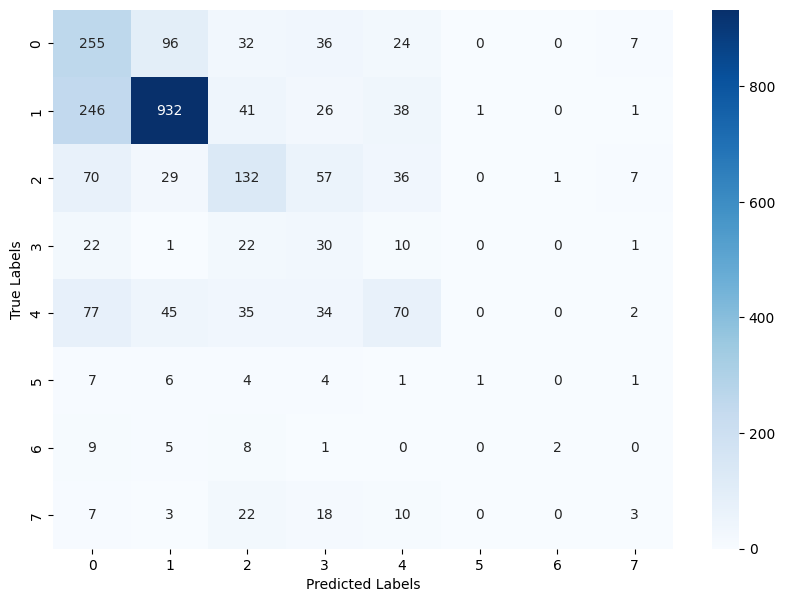

In [112]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

###Summary of Confusion Matrix
Classes 3, 4, 5, 6, and 7 show a particular need for augmentation due to low true positives and high confusion with other classes. Class 0 also needs attention due to being frequently confused with other high-incidence classes. These focused augmentations aim to enhance the model's ability to distinguish these classes more clearly, which should improve overall accuracy and reduce misclassifications.

We will try and address this through resampling methods. Ideally we would just augment the data, but using the challenge dataset is... more of a challenge ✊

After several instances of resampling, using designated weights at 10x multiples and then iterating through another set of compilation training at the model fit, and focused epochs un the undersampled data we have F1 scores showing on all classes.  

We did attempt to create a GAN model and its in our experimental model folder. We were not succesful in creating images that scored high enough to place in our image set.
####SEE section of repository labled experimental_code for our attempt at creating GAN images.

## Step 7: Further Model Evaluation and Misclassification Analysis

The process starts by loading a previously trained model from disk using `load_model`. This model is then used to evaluate its performance on unseen data provided by a test generator. The evaluation consists of several steps:

#### Loading the Model
The model is loaded from a saved file, ensuring that the most effective version of the model, as determined by prior validations, is used for evaluations.

#### Fetching Predictions and Labels
A custom function `get_predictions_and_labels` is employed to iterate over the test generator. This function fetches batches of data (both images and metadata) and corresponding labels, then uses the model to predict each batch. Predictions and true labels are accumulated from all batches, allowing for comprehensive evaluation.

#### Calculating Confusion Matrix and Classification Report
Once predictions are gathered they are converted from softmax probabilities to class predictions using `np.argmax`. With predictions and true labels in hand, a confusion matrix is generated to visually assess the model's performance across different classes. This matrix highlights which classes are being confused with others, providing insight into potential biases or weaknesses in the model.

A classification report is also generated to provide key metrics for each class, such as precision, recall, and F1-score. This report helps in understanding the model's accuracy and identifying classes that might require more focus during further model training.

#### Visualizing Misclassified Examples
Finally, the script identifies and displays a set of misclassified images along with their true and predicted labels. This visualization is crucial for diagnosing what might be causing the errors, potentially guiding further data collection, augmentation strategies, or model adjustments.

Each of these steps plays a role in evaluating the model's real-world applicability and robustness, ensuring that the model not only performs but also meets practical expectations.

1. Lets just run it a few more times and see if it can get any better before it gets any worse... now that its better trained at the low classes, lets let it go without conditional training. bad idea, overfit right away
2. lets try a method to slow the learning rate down as the metrics degrade using ReduceLROnPlateau. ok, that almost worked....
3. lets use ReduceLR on the Conditionals and slow down the LR even more and ake it loop until it doesnt improve... minor improvement
4. lets make a conditional training custom callback and no matter what it outputs, that is our project... because we are out of time ⏰. seems to be overfitting on the underrepped classes right away, maybe using history on the model was not the best choice.

Clearly overfitting as epochs continue, however i think runing this code from the start, this method would yield the best results. due to a colab disconect our group doesnt have the time to re run retraining the inital model without using history.fit again


In [116]:
class ConditionalDataSwitch(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Conditional logic to switch data generators
        if epoch % 5 == 0:
            print("Focusing on underrepresented classes")
            # Update train_gen for underrepresented classes
            self.model.train_gen = DualInputGenerator(
                image_paths=X_train_underrepresented['image_path'].values,
                metadata=X_train_underrepresented.drop(columns=['image', 'image_path', 'lesion_id']).values,
                labels=y_train_underrepresented.values,
                batch_size=32
            )
        else:
            print("Training on full dataset")
            # Update train_gen for the full dataset
            self.model.train_gen = DualInputGenerator(
                image_paths=X_train['image_path'].values,
                metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
                labels=y_train.values,
                batch_size=32
            )

# Defined callbacks including ReduceLROnPlateau
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint(filepath='/content/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1, start_epoch=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, min_lr=1e-6, verbose=1),  # More gradual reduction .5 to .25
    ConditionalDataSwitch()  # Custom callback for switching data generators based on epoch
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    #epochs=20,
    #run one epoch for grading to show code
    epochs=2,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks_list,
    class_weight=adjusted_weights_indices
)

Focusing on underrepresented classes
633/633 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9706
Epoch 1: val_loss improved from inf to 1.55526, saving model to /content/best_model.keras
633/633 [==============================] - 407s 643ms/step - loss: 0.1380 - accuracy: 0.9706 - val_loss: 1.5553 - val_accuracy: 0.6594 - lr: 1.2617e-04


everything is overfitting on this run now, these models are typically in the high 60's, lower losses. I think we iterated these models too many times today and since we are calling history its making issues

1/1 [==============================] - 0s 168ms/step
Confusion Matrix:
 [[ 244  131   36    6   30    0    0    3]
 [ 138 1072   48    2   23    2    0    0]
 [  29   54  198   14   30    0    0    7]
 [  21    7   28   15   11    0    0    4]
 [  72   80   30    6   74    0    0    1]
 [   3   10    5    0    0    5    0    1]
 [   1    5    7    0    1    1    9    1]
 [   9    8   24    1   13    0    0    8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.54      0.50       450
           1       0.78      0.83      0.81      1285
           2       0.53      0.60      0.56       332
           3       0.34      0.17      0.23        86
           4       0.41      0.28      0.33       263
           5       0.62      0.21      0.31        24
           6       1.00      0.36      0.53        25
           7       0.32      0.13      0.18        63

    accuracy                           0.64      2528
   macro avg    

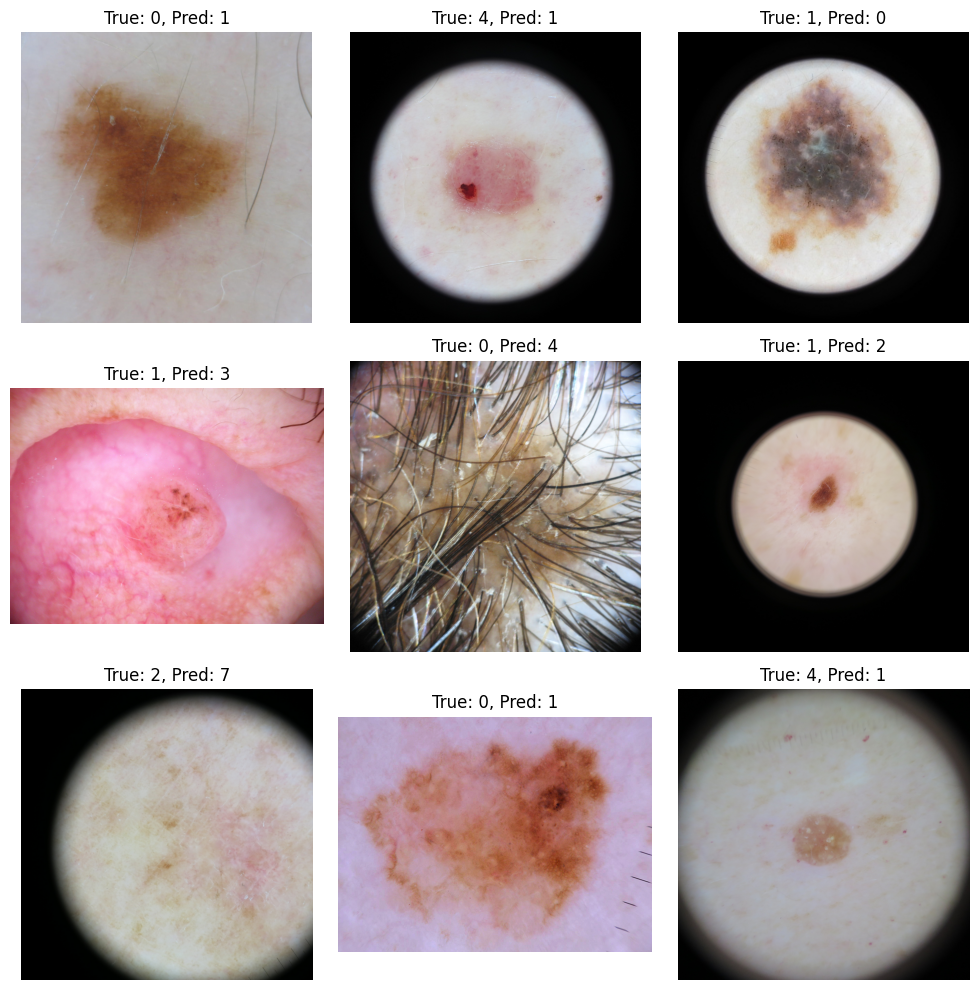

In [117]:
# Load the model
model = load_model('/content/best_model.keras')

# Function to fetch data and labels from the generator
def get_predictions_and_labels(generator):
    predictions = []
    true_labels = []
    for _ in range(len(generator)):
        # Getting the next batch of data
        (images, metadata), labels = generator.__getitem__(_)
        # Predict this batch
        batch_predictions = model.predict([images, metadata])
        # Store predictions and labels
        predictions.append(batch_predictions)
        true_labels.append(labels)

    # Concatenate all batches
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)

    return predictions, true_labels

# Using the test generator to get predictions and labels
predictions, true_labels = get_predictions_and_labels(test_gen)

# Convert softmax probabilities to class predictions
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:\n', cm)

# Generate a classification report
print('\nClassification Report:\n', classification_report(true_classes, predicted_classes))

# Identify misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f'Total misclassified samples: {len(misclassified_indices)}')

# Assuming you want to visualize some misclassified images:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(misclassified_indices):
        idx = misclassified_indices[i]
        img = test_gen.image_paths[idx]  # Assuming image paths are stored here
        true_label, pred_label = true_classes[idx], predicted_classes[idx]
        ax.imshow(plt.imread(img))  # Reading the image from path
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')
plt.tight_layout()
plt.show()

###After running more Conditional data training we are ready for some more testing

### Evaluation of Classifier Performance Using ROC Curves

To evaluate the performance of the classifier on a per-class basis, the Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC) are computed. These metrics are crucial for assessing the model's ability to distinguish between classes. Here's a breakdown of the steps involved in this evaluation:

#### Preparing Labels and Predictions
Firstly, the true labels are converted to a 1-dimensional array if they are not already in this format, ensuring they can be directly compared with the predicted probabilities. Predictions are checked to ensure they contain a probability for each class.

#### Computing ROC Curves and AUC Values
For each class, the ROC curve is calculated by:
- Isolating the prediction probabilities for that class.
- Creating a binary outcome array for the class, where the class of interest is labeled `1` and all others `0`.
- Using the `roc_curve` function from `sklearn.metrics` to compute the true positive rate (TPR) and false positive rate (FPR) at various threshold settings.
- Calculating the AUC value to quantify the overall ability of the model to discriminate between positive and negative classes for each specific class.

#### Plotting the ROC Curves
Each class's ROC curve is plotted with a unique color, and the AUC score is displayed in the legend to provide a visual and numerical representation of classifier performance. The diagonal line represents a random classifier's performance for comparison.

- **X-axis**: False Positive Rate (FPR) — represents the proportion of negative data points that are mistakenly considered positive.
- **Y-axis**: True Positive Rate (TPR) — represents the proportion of actual positives correctly identified.

The area under each curve (AUC) provides a single measure of overall performance regardless of the classification threshold. The closer the AUC is to 1, the better the model is at predicting positive classes as positive and negative classes as negative. Values closer to 0.5 suggest no discriminative ability, equivalent to random guessing.

This detailed analysis helps in identifying which classes the model performs well on and which ones might require further tuning, potentially guiding further data augmentation, additional training, or algorithm adjustments.


Predictions appear to be properly formatted.


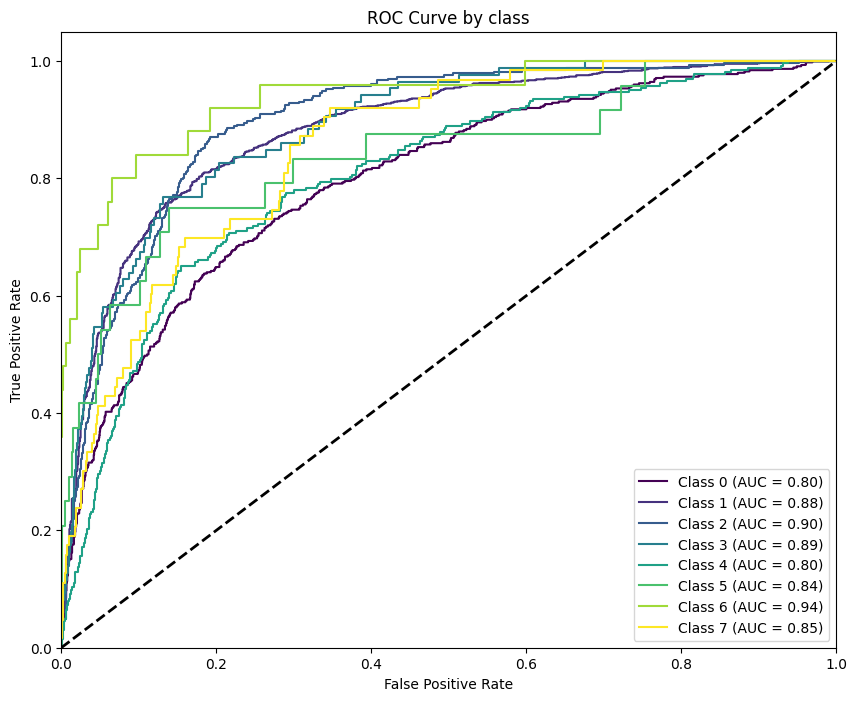

In [118]:
# Ensure that true_labels is a 1D array of class indices
if len(true_labels.shape) > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Ensure predictions are probabilities
if predictions.shape[1] == len(np.unique(true_labels)):
    print("Predictions appear to be properly formatted.")

n_classes = len(np.unique(true_labels))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Isolate the probabilities for the current class
    class_probs = predictions[:, i]
    # Create a binary outcome for this class
    class_true = (true_labels == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(class_true, class_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by class')
plt.legend(loc="lower right")
plt.show()

##Step 8: "Teachers: The Architects of Tomorrow's... Model"

### Knowledge Distillation:
Uses our current model (the "teacher") to train a simpler model (the "student"). The student model learns to mimic the teacher model's behavior while often generalizing better on unseen data due to its simplicity.

### Fine-tuning with Regularization & more Conditional Traiing:
Load the weights of the best model and continue training with increased regularization (L1/L2 regularization) to force the model to learn more robust features, just because these students are in a BOOTCAMP we will reapply the conditional training methods used on the original model.

In [120]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import load_model

# Load the teacher model
teacher_model = load_model('/content/best_model.keras')

# Define underrepresented classes based on higher class weights or lower presence
underrepresented_classes = ['MEL', 'BCC', 'DF', 'SCC']  # Adjust as necessary based on your class definition and needs

#
# Map class labels to indices
class_labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
class_indices = {label: idx for idx, label in enumerate(class_labels)}

# Adjust weights dictionary to use integer indices
adjusted_weights_indices = {class_indices[key]: value for key, value in weights.items()}

# Filter y_train to get indices where any of the underrepresented classes occur
underrepresented_indices = y_train[underrepresented_classes].sum(axis=1) > 0

# Filter X_train and y_train to get only the samples belonging to underrepresented classes
X_train_underrepresented = X_train[underrepresented_indices]
y_train_underrepresented = y_train[underrepresented_indices]

def build_student_model(input_shape_image=(224, 224, 3), num_metadata_features=13, num_classes=8):
    image_input = Input(shape=input_shape_image, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    image_branch = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)

    metadata_input = Input(shape=(num_metadata_features,), name='metadata_input')
    y = Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(metadata_input)
    metadata_branch = BatchNormalization()(y)

    combined = concatenate([image_branch, metadata_branch])
    z = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation='softmax')(z)

    student_model = Model(inputs=[image_input, metadata_input], outputs=output)
    student_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return student_model

student_model = build_student_model()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint(filepath='/content/student_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Conditional Training Setup
for epoch in range(10):  # Assuming a total of 10 epochs
    if epoch % 5 == 0:
        # Use a generator or loader for underrepresented classes
        print("Focusing on underrepresented classes")
        train_gen = DualInputGenerator(
            image_paths=X_train_underrepresented['image_path'].values,
            metadata=X_train_underrepresented.drop(columns=['image', 'image_path', 'lesion_id']).values,
            labels=y_train_underrepresented.values,
            batch_size=32
        )
    else:
        # Use the general training generator
        print("Training on full dataset")
        train_gen = DualInputGenerator(
            image_paths=X_train['image_path'].values,
            metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
            labels=y_train.values,
            batch_size=32
        )


print(adjusted_weights_indices)

# Adjusted class weights in our training
history = student_model.fit(
    train_gen,
    validation_data=val_gen,
    #epochs=10,
    epochs=2,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks,
    class_weight=adjusted_weights_indices
)

#like python AI students, these guys alwyas start of really terrible at this

Focusing on underrepresented classes
Training on full dataset
Training on full dataset
Training on full dataset
Training on full dataset
Focusing on underrepresented classes
Training on full dataset
Training on full dataset
Training on full dataset
Training on full dataset
{0: 10.0, 1: 1.0, 2: 10.0, 3: 1.0, 4: 1.0, 5: 10.0, 6: 1.0, 7: 10.0}
Epoch 1/2
633/633 [==============================] - ETA: 0s - loss: 14.4287 - accuracy: 0.2650
Epoch 1: val_loss improved from inf to 3.42349, saving model to /content/student_best_model.keras
633/633 [==============================] - 432s 679ms/step - loss: 14.4287 - accuracy: 0.2650 - val_loss: 3.4235 - val_accuracy: 0.3366
Epoch 2/2
633/633 [==============================] - ETA: 0s - loss: 8.3993 - accuracy: 0.2532
Epoch 2: val_loss improved from 3.42349 to 2.98516, saving model to /content/student_best_model.keras
633/633 [==============================] - 433s 683ms/step - loss: 8.3993 - accuracy: 0.2532 - val_loss: 2.9852 - val_accuracy: 0.

In [ ]:
test_loss, test_accuracy = student_model.evaluate(test_gen)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

####These students requires a lot of training....
But it looks like they are improving over time; under 20 to over 60% depending on augmentation!  This round of students we will focus on adjusting their learnng rate & keeping conditionals to keep them studying for a long time


In [122]:
# Set the filepath for the saved model
filepath = '/content/student_best_model.keras'

# Define the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

# Define the EarlyStopping callback to stop training when no improvement is seen
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Define ReduceLROnPlateau to adjust the learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001
)

callbacks = [early_stopping, checkpoint, reduce_lr]

# Conditional Training Setup
for epoch in range(10):  # Assuming a total of 10 epochs
    if epoch % 5 == 0:
        print("Focusing on underrepresented classes")
        # Use a generator or loader for underrepresented classes
        train_gen = DualInputGenerator(
            image_paths=X_train_underrepresented['image_path'].values,
            metadata=X_train_underrepresented.drop(columns=['image', 'image_path', 'lesion_id']).values,
            labels=y_train_underrepresented.values,
            batch_size=32
        )
    else:
        print("Training on full dataset")
        # Use the general training generator
        train_gen = DualInputGenerator(
            image_paths=X_train['image_path'].values,
            metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
            labels=y_train.values,
            batch_size=32
        )

# Printing the adjusted weights indices for clarity in logs
print(adjusted_weights_indices)

# Start the training process
history_continued = student_model.fit(
    train_gen,
    validation_data=val_gen,
    #epochs=80
    epochs=2,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks,
    class_weight=adjusted_weights_indices
)


Focusing on underrepresented classes
Training on full dataset
Training on full dataset
Training on full dataset
Training on full dataset
Focusing on underrepresented classes
Training on full dataset
Training on full dataset
Training on full dataset
Training on full dataset
{0: 10.0, 1: 1.0, 2: 10.0, 3: 1.0, 4: 1.0, 5: 10.0, 6: 1.0, 7: 10.0}
Epoch 1/2
633/633 [==============================] - ETA: 0s - loss: 7.4565 - accuracy: 0.2472
Epoch 1: val_loss improved from inf to 2.82651, saving model to /content/student_best_model.keras
633/633 [==============================] - 434s 685ms/step - loss: 7.4565 - accuracy: 0.2472 - val_loss: 2.8265 - val_accuracy: 0.2654 - lr: 1.0000e-04
Epoch 2/2
633/633 [==============================] - ETA: 0s - loss: 7.2245 - accuracy: 0.2487
Epoch 2: val_loss improved from 2.82651 to 2.79884, saving model to /content/student_best_model.keras
633/633 [==============================] - 436s 689ms/step - loss: 7.2245 - accuracy: 0.2487 - val_loss: 2.7988 - v


applied conditional training

Implement a training regimen where in certain epochs, the model trains exclusively or predominantly on data from underrepresented classes, perhaps using attention mechanisms during these phases.

In [ ]:
test_loss, test_accuracy = student_model.evaluate(test_gen)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


####Lets figure out why these students are so terrible
issue 1 addressed; imbalanced data, have to run through many epochs w conditionals. Can use ReduceLR in callbacks again, worked ok in previous iteratoins


In [ ]:
def evaluate_model(model, generator):
    num_classes = 8  # Adjust this based on your actual number of classes

    # Collect all predictions and true labels from the generator
    predictions, labels = [], []
    for (images, metadata), label in generator:
        preds = model.predict([images, metadata])
        predictions.extend(np.argmax(preds, axis=1))
        labels.extend(np.argmax(label, axis=1))

    # Generate confusion matrix and classification report
    cm = confusion_matrix(labels, predictions)
    clr = classification_report(labels, predictions, target_names=[str(i) for i in range(num_classes)])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=[str(i) for i in range(num_classes)])
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=[str(i) for i in range(num_classes)])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(clr)

evaluate_model(student_model, val_gen)

###Teamwork makes the dream work.

lets see how they perform as a team

In [ ]:
# Assuming models are already loaded; otherwise, load them:
teacher_model = load_model('/content/best_model.keras')
student_model = load_model('/content/best_student_model.keras')

# Function to evaluate ensemble accuracy
def evaluate_ensemble_accuracy(teacher_model, student_model, test_gen):
    correct_count = 0
    total_count = 0

    # Correctly unpack the data from the generator
    for (images, metadata), labels in test_gen:
        # Predict with both models
        teacher_predictions = teacher_model.predict([images, metadata])
        student_predictions = student_model.predict([images, metadata])

        # Average the predictions (change based on each model's acc results)
        averaged_predictions = (teacher_predictions * 0.8) + (student_predictions * 0.2)

        # Convert probabilities to predicted class index
        predicted_classes = np.argmax(averaged_predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)  # Assuming labels are one-hot encoded

        # Increment correct count
        correct_count += np.sum(predicted_classes == true_classes)
        total_count += labels.shape[0]

    # Calculate accuracy
    accuracy = correct_count / total_count
    return accuracy

# Evaluate ensemble accuracy using the provided test generator
accuracy = evaluate_ensemble_accuracy(teacher_model, student_model, test_gen)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))

####A weighted democracy

In [ ]:
# Assuming models are already loaded; otherwise, load them:
teacher_model = load_model('/content/best_model.keras')
student_model = load_model('/content/best_student_model.keras')

# Function to evaluate ensemble accuracy with weighted voting
def evaluate_ensemble_accuracy(teacher_model, student_model, test_gen):
    correct_count = 0
    total_count = 0

    # Weights based on model accuracy
    teacher_weight = 0.65
    student_weight = 0.35

    # Correctly unpack the data from the generator
    for (images, metadata), labels in test_gen:
        # Predict with both models
        teacher_predictions = teacher_model.predict([images, metadata])
        student_predictions = student_model.predict([images, metadata])

        # Convert probabilities to class predictions
        teacher_predicted_classes = np.argmax(teacher_predictions, axis=1)
        student_predicted_classes = np.argmax(student_predictions, axis=1)

        # Collect votes weighted by model accuracy
        # Create an array to hold votes for each class
        votes = np.zeros((labels.shape[0], teacher_predictions.shape[1]))  # shape[1] gives number of classes

        # Add votes from each model based on predicted class and weight
        np.add.at(votes, (np.arange(len(teacher_predicted_classes)), teacher_predicted_classes), teacher_weight)
        np.add.at(votes, (np.arange(len(student_predicted_classes)), student_predicted_classes), student_weight)

        # Determine final predicted class based on total votes
        predicted_classes = np.argmax(votes, axis=1)
        true_classes = np.argmax(labels, axis=1)  # Assuming labels are one-hot encoded

        # Increment correct count
        correct_count += np.sum(predicted_classes == true_classes)
        total_count += labels.shape[0]

    # Calculate accuracy
    accuracy = correct_count / total_count
    return accuracy


# we still need to define or load 'test_gen' somewhere before calling this function
accuracy = evaluate_ensemble_accuracy(teacher_model, student_model, test_gen)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))


OK, well not every dream comes true, but we came this far, lets apply the models

# Step 8: **The Interface** ⚡

---




User Interface (UI)
A simple web-based UI allows users to upload lesion images, input relevant metadata, and receive a prediction. We will use Gradio as learned in class for this model.

In [ ]:
! pip install gradio --upgrade
! pip install --upgrade gradio
! pip install gradio ai

In [ ]:
import gradio as gr
from gradio import Image, Number, Radio, Dropdown

import numpy as np
from PIL import Image
import os
from PIL import Image as PILImage

import tensorflow as tf
from tensorflow import keras

### Model Loading and Prediction Testing

#### Loading the Pre-trained Model
The script begins by loading a pre-trained model from a specified path. This model is essential for predicting the type of skin lesions based on image data and associated metadata.

#### Model Architecture Overview
Once the model is loaded, `model.summary()` is called to print the architecture of the model. This summary provides insight into the model's layers, their shapes, and parameters, which is crucial for understanding how the model processes input data.

#### Dummy Prediction
To ensure the model is functioning correctly, a dummy input array is created using random data, shaped appropriately for the model's expected input (in this case, 224x224x3 for image data). This array is then used to make a prediction, testing the model's readiness for actual data.

### Image Preprocessing and Prediction Explanation Function

#### Image Preprocessing
The script defines a function `preprocess_image` that takes an uploaded image file, resizes it to fit the model's input requirements, normalizes the pixel values, and expands its dimensions to include a batch size for model input compatibility.

#### Prediction and Explanation Generation
Another function, `predict_and_explain`, is designed to handle the end-to-end process from image and metadata input through to generating a human-readable explanation of the prediction. This function:
- Preprocesses the input image for model prediction.
- Uses the model to predict the lesion type based on the image.
- Maps the prediction to a readable class description.
- Optionally, uses GPT-3 to generate a detailed explanation of the diagnosis, integrating the lesion's metadata for a comprehensive overview.

### User Interface for Skin Lesion Classification

#### Interface Setup
The script utilizes `gr.Interface` from the Gradio library to create an interactive web interface. This interface allows users to upload images of skin lesions and input relevant metadata (age, sex, and anatomical site).

#### Interface Launch
Finally, the interface is launched, making it accessible via a web browser. Users can interact with the model, upload images, input metadata, and receive predictions along with explanations right in the interface.

### Usage and Disclaimer
The interface includes a title and a detailed description, advising users on how to use the tool and noting that predictions should not replace professional medical advice. This ensures users understand the context and limitations of the model predictions.

This comprehensive setup allows for an accessible and user-friendly way to leverage advanced machine learning models for educational and preliminary diagnostic support in dermatology.


####Test drive models here ⏬

In [ ]:
# Load the model
model_path = '/content/best_model.h5'
model = keras.models.load_model(model_path)

# Print model summary
model.summary()

# Create a dummy input array for metadata
test_metadata = np.random.random((1, 13))

# Combine image data and metadata
test_input_image = np.random.random((1, 224, 224, 3))
test_input = [test_input_image, test_metadata]

# Make a prediction
test_prediction = model.predict(test_input)
print(test_prediction)


###Tri-Model Predictions
##The Sudents & The Teachers 🥇
###...and a little help from TA's
###An Ode to Python AI Coding Bootcamp

**Initial Binary Classification**: Here we use the binary medical classifier, Cancer-Net SCa Model, to determine if a lesion is malignant or benign. This first step allows the system to filter and focus the subsequent predictions.

**Conditional Multiclass Classification**:
- **If Malignant**: Route the input to the student-teacher model but restrict the classification to the malignant classes only. This reduces the complexity of the prediction task for these cases.
- **If Benign**: Proceed with the student-teacher model using all classes or possibly excluding known malignant classes based on the prior binary result.

This conditional approach leverages the strength of both models and optimizes the classification task by reducing the decision space when appropriate, potentially increasing overall accuracy.



In [ ]:
# Load models
teacher_model = load_model('/content/best_model.keras')
student_model = load_model('/content/best_student_model (1).keras')
binary_classifier = load_model('/content/best_cancer_net_sca_model.keras')

# Diagnosis descriptions
diagnosis_descriptions = {
    'MEL': 'Melanoma: a serious form of skin cancer that begins in cells known as melanocytes.',
    'NV': 'Melanocytic nevus: a common type of skin growth that often appears as a small, dark brown spot.',
    'BCC': 'Basal cell carcinoma: a type of skin cancer that most often develops on areas exposed to the sun.',
    'AK': 'Actinic keratosis: a rough, scaly patch on the skin caused by years of sun exposure.',
    'BKL': 'Benign keratosis: a non-cancerous skin condition that appears as a waxy brown, black, or tan growth.',
    'DF': 'Dermatofibroma: a common growth on the skin, usually found on the lower legs, that can be pink, red, or brown.',
    'VASC': 'Vascular lesion: a type of abnormal growth or mark on the skin that is made up of blood vessels.',
    'SCC': 'Squamous cell carcinoma: a common form of skin cancer that develops in the squamous cells.'
}

def preprocess_image(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = np.array(image)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    image is np.expand_dims(image, axis=0)
    return image

def encode_metadata(age, sex, location):
    # Sex encoding: ['Male', 'Female', 'Other']
    sex_encoded = [1 if sex == category else 0 for category in ['Male', 'Female', 'Other']]

    # Location encoding: extend for specific torso categories
    location_categories = ['Head/Neck', 'Upper Extremity', 'Lower Extremity',
                           'Anterior Torso', 'Lateral Torso', 'Posterior Torso',
                           'Palms/Soles', 'Oral/Genital', 'Other']
    location_encoded = [1 if location == loc else 0 for loc in location_categories]

    # Combine age, sex, and location into one array
    return np.array([[age] + sex_encoded + location_encoded], dtype=float)

def preprocess_image(image):
    """Preprocesses the input image for prediction."""
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = np.array(image)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def encode_metadata(age, sex, location):
    """Encodes the metadata for prediction, ensuring proper one-hot encoding and inclusion of all features."""
    # Sex encoding: ['Male', 'Female', 'Other']
    sex_encoded = [1 if sex == category else 0 for category in ['Male', 'Female', 'Other']]

    # Extend location encoding for specific torso categories
    location_categories = [
        'Head/Neck', 'Upper Extremity', 'Lower Extremity',
        'Anterior Torso', 'Lateral Torso', 'Posterior Torso',
        'Palms/Soles', 'Oral/Genital', 'Other'
    ]
    location_encoded = [1 if location == loc else 0 for loc in location_categories]

    # Combine age, sex, and location into one array
    metadata = np.array([[age] + sex_encoded + location_encoded], dtype=float)
    return metadata

def predict_and_explain(image, age, sex, location):
    """
    Makes predictions using the provided image and metadata, and explains the output based on binary classifier's lead.
    """
    # Process image
    image = preprocess_image(image)

    # Prepare metadata correctly for all models
    metadata = encode_metadata(age, sex, location)

    # Predict potential malignancy with the binary classifier
    is_malignant = binary_classifier.predict([image, metadata])[0][0] > 0.5

    # Ensure both teacher and student models receive both the processed image and metadata
    teacher_prediction = teacher_model.predict([image, metadata])[0]
    student_prediction = student_model.predict([image, metadata])[0]
    average_prediction = (teacher_prediction * 0.9) + (student_prediction * 0.1)

    # Decision based on malignancy
    if is_malignant:
        relevant_classes = ['MEL', 'BCC', 'SCC']
    else:
        relevant_classes = ['NV', 'AK', 'BKL', 'DF', 'VASC']

    mask = np.isin(np.array(list(diagnosis_descriptions.keys())), relevant_classes)
    masked_prediction = average_prediction[mask]
    predicted_class = np.argmax(masked_prediction)
    class_labels = np.array(list(diagnosis_descriptions.keys()))[mask]
    predicted_label = class_labels[predicted_class]
    description = diagnosis_descriptions[predicted_label]

    return f"Predicted Lesion Type: {predicted_label}\nDescription: {description}\nMalignant: {'Yes' if is_malignant else 'No'}"

# Example setup for your Gradio interface
iface = gr.Interface(
    fn=predict_and_explain,
    inputs=[
        gr.Image(image_mode='RGB', sources=["upload", "webcam"], type='pil'),
        gr.Number(label="Age"),
        gr.Radio(choices=['Male', 'Female', 'Other'], label="Sex"),
        gr.Dropdown(choices=['Head/Neck', 'Upper Extremity', 'Lower Extremity', 'Anterior Torso', 'Lateral Torso', 'Posterior Torso', 'Palms/Soles', 'Oral/Genital', 'Other'], label="Anatomical Site")
    ],
    outputs="text",
    title="Skin Lesion Classifier",
    description="Upload an image of a skin lesion and enter metadata to predict its type. The results provide a preliminary classification and are not a substitute for professional medical advice."
)

iface.launch(debug=True)


# Skin Lesion Classification Project Summary

&emsp;&emsp;This project focused on classifying skin lesions using deep learning techniques with the ISIC 2019 dataset. A central aspect was the development of a dual-input model that integrates both image data and patient metadata, aiming to leverage additional context for improved diagnostic accuracy. TheDualInputGenerator was utilized for handling the simultaneous input of images and metadata during training. This setup facilitated the effective integration of both data types. The training process was fine-tuned using strategies like early stopping and model checkpoints, ensuring excellent model performance without extensive straining the our computational resources. <br>
<br>
&emsp;&emsp;A Gradio interface was deployed to allow user interaction with the model, enabling uploads of skin lesion images and entry of relevant metadata for real-time predictions. This user-friendly interface makes the model accessible to non-experts and provides educational insights into different types of skin lesions, demonstrating the application's potential as a diagnostic aid. <br>
<br>
&emsp;&emsp;The project highlighted the application of mixed data models in medical image analysis, demonstrating how machine learning can be applied in healthcare settings. It also underscored the importance of user interface design in making complex models accessible and useful to a broader audience. There is potential to expand the model to include more diagnostic categories and enhance the interface with more detailed explanations of predictions. Further development could involve integrating AI-driven insights or additional data sources. User testing and feedback will be essential in refining the tool to better meet user needs. The ultimate goal could be to integrate this tool into medical systems for preliminary diagnostics.